### Testing Neural Networks for wind generation prediction ###

Given a value of 10m wind speed, we want to predict the wind power generation.



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# load the observed data
fpath = "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv"

# load the data using pandas
df = pd.read_csv(fpath, index_col=0, parse_dates=True)

In [3]:
df.keys()


Index(['solar_power', '100m_wind_speed', '10m_wind_speed', 'solar_irradiance',
       'ofs_cfs', 'ons_cfs', 't2m_no_detrend', 't2m_2020_detrend',
       'United_Kingdom_demand', 'United_Kingdom_wd_demand', 'wind_gen',
       'demand_net_wind', 'wd_demand_net_wind'],
      dtype='object')

In [13]:
df

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=10753, freq=None)

Text(0, 0.5, 'Wind Generation (GW)')

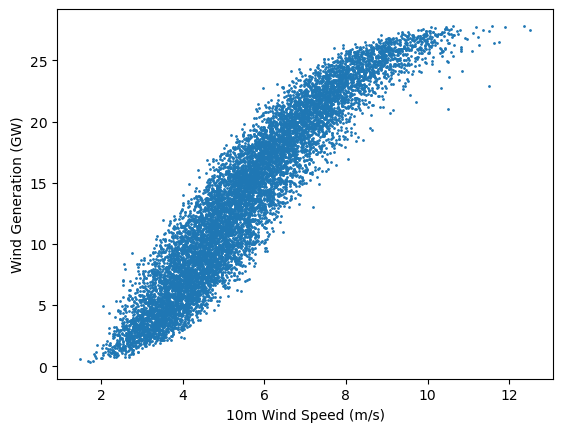

In [4]:
# plot a scatter of the 10m wind speed against wind generation
fig, ax = plt.subplots()

ax.scatter(df['10m_wind_speed'], df['wind_gen'], s=1)

# set the axis labels
ax.set_xlabel('10m Wind Speed (m/s)')

ax.set_ylabel('Wind Generation (GW)')

Give up on ML for now and just fit a sigmoid instead.

In [5]:
# Set up the sigmoid fit
def sigmoid(x, L, x0, k, b):
    """
    Computes the sigmoid function.

    Parameters:
    x (float or array-like): The input value(s) for which to compute the sigmoid function.
    L (float): The curve's maximum value.
    x0 (float): The x-value of the sigmoid's midpoint.
    k (float): The steepness of the curve.
    b (float): The value to shift the curve vertically.

    Returns:
    float or array-like: The computed sigmoid value(s).
    """
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y

# include an initial guess for the parameters
p0 = [max(df['wind_gen']), np.median(df['10m_wind_speed']), 1, min(df['wind_gen'])]

In [6]:
# fit the sigmoid function to the data
popt, pcov = curve_fit(sigmoid, df['10m_wind_speed'], df['wind_gen'], p0=p0, method='dogbox')

In [7]:
# the optimized parameters
popt

array([30.35851841,  5.26331701,  0.59485836, -2.38855419])

In [8]:
# the covariance matrix
pcov

array([[ 2.74437093e-01, -1.11002440e-02, -6.77212747e-03,
        -1.82206933e-01],
       [-1.11002440e-02,  1.07465543e-03,  2.54460837e-04,
         9.67866802e-03],
       [-6.77212747e-03,  2.54460837e-04,  1.74643966e-04,
         4.41952045e-03],
       [-1.82206933e-01,  9.67866802e-03,  4.41952045e-03,
         1.29939350e-01]])

/tmp/ipykernel_805556/3781557917.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, sigmoid(x, *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f' % tuple(popt), color='orange')


Text(0.05, 0.95, '$R^2=0.90$\n$MSE=4.76$')

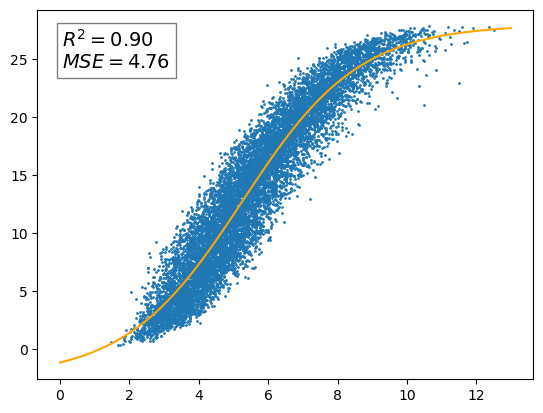

In [9]:
# Set up a figure
fig, ax = plt.subplots()

# plot the scatter of the data
ax.scatter(df['10m_wind_speed'], df['wind_gen'], s=1)

# plot the sigmoid fit
x = np.linspace(0, round(max(df['10m_wind_speed'])), 100)

ax.plot(x, sigmoid(x, *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f' % tuple(popt), color='orange')

# calculte the r2 value
r2 = r2_score(df['wind_gen'], sigmoid(df['10m_wind_speed'], *popt))

# calculate the mean squared error
mse = mean_squared_error(df['wind_gen'], sigmoid(df['10m_wind_speed'], *popt))

# include these values in a textbox in the top left
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2, ),
    r'$MSE=%.2f$' % (mse, )))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5)
)


/tmp/ipykernel_805556/1995215400.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label='fit: y=%5.3fx + %5.3f' % (model.coef_[0][0], model.intercept_), color='orange')
/tmp/ipykernel_805556/1995215400.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label='fit: y=%5.3fx + %5.3f' % (model.coef_[0][0], model.intercept_), color='orange')


Text(0.05, 0.95, '$R^2=0.88$\n$MSE=5.60$')

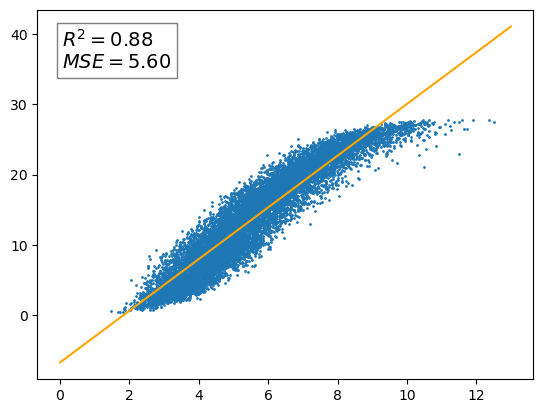

In [10]:
# Quantify a linear regression fit
from sklearn.linear_model import LinearRegression

# set up the linear regression model
model = LinearRegression()

# fit the model to the data
model.fit(df['10m_wind_speed'].values.reshape(-1, 1), df['wind_gen'].values.reshape(-1, 1))

# set up a figure
fig, ax = plt.subplots()

# plot the scatter of the data
ax.scatter(df['10m_wind_speed'], df['wind_gen'], s=1)

# plot the linear regression fit
x = np.linspace(0, round(max(df['10m_wind_speed'])), 100)

ax.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label='fit: y=%5.3fx + %5.3f' % (model.coef_[0][0], model.intercept_), color='orange')

# calculate the r2 value
r2 = model.score(df['10m_wind_speed'].values.reshape(-1, 1), df['wind_gen'].values.reshape(-1, 1))

# calculate the mean squared error
mse = mean_squared_error(df['wind_gen'], model.predict(df['10m_wind_speed'].values.reshape(-1, 1)))

# include these values in a textbox in the top left
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2, ),
    r'$MSE=%.2f$' % (mse, )))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5)
)

### Compare DnW and synthetic DnW ###

* First compare the demand with demand from temperature (should be the same?).
* Then consider the wind gen against synthetic wind generation (similar-ish).
* Then take the difference between these and compare the demand net wind with synthetic demand net wind.


First process temperature into demand

In [15]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# load the obs temperature data
df_obs_tas = pd.read_csv(f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv")

# Convert time column to datetime
df_obs_tas['time'] = pd.to_datetime(df_obs_tas['time'], origin='1950-01-01', unit='D')

# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]

# set up a column for the data in celsius
df_obs_tas['tas_c'] = df_obs_tas['data'] - 273.15

Calculate heating degree days and cooling degree days

In [17]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas['hdd'] = df_obs_tas['tas_c'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd'] = df_obs_tas['tas_c'].apply(lambda x: max(0, x - cdd_base))

Apply the regression coefficients for the UK to calculate weather dependent demand

In [18]:
# Set up the path to the regression coeffs
regr_coeffs = "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand
df_obs_tas["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd"]) +
    (cdd_coeff_uk * df_obs_tas["cdd"])
)

In [19]:
df_obs_tas.describe()

,time,data,tas_c,hdd,cdd,UK_demand
count,10753,10753.000000,10753.000000,10753.000000,10753.0,10753.000000
mean,1989-07-02 02:54:29.561982720,278.891664,5.741664,9.758826,0.0,42.351870
min,1960-01-01 00:00:00,266.208392,-6.941608,0.000000,0.0,35.056087
25%,1974-11-16 00:00:00,276.537787,3.387787,7.388341,0.0,40.579675
50%,1989-10-01 00:00:00,278.854584,5.704584,9.795416,0.0,42.379225
75%,2004-02-15 00:00:00,281.261659,8.111659,12.112213,0.0,44.111282
max,2018-12-31 00:00:00,290.817681,17.667681,22.441608,0.0,51.833628
std,NaN,3.476327,3.476327,3.474857,0.0,2.597833


/tmp/ipykernel_805556/1210572660.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, x, 'r-', color='orange')


Text(0, 0.5, 'CLEARHEADS Demand (GW)')

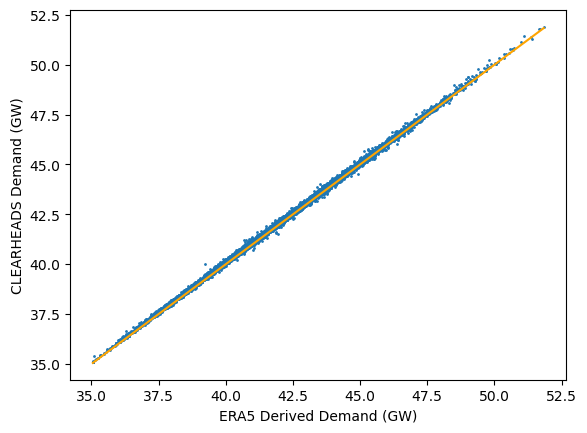

In [23]:
# Compare the derived demand with the observed demand
fig, ax = plt.subplots()

# plot a scatter of the observed demand against the derived demand
ax.scatter(df_obs_tas["UK_demand"], df["United_Kingdom_wd_demand"], s=1)

# include a 1:1 line
x = np.linspace(min(df_obs_tas["UK_demand"]), max(df_obs_tas["UK_demand"]), 100)

ax.plot(x, x, 'r-', color='orange')

# include the axis labels
ax.set_xlabel("ERA5 Derived Demand (GW)")
ax.set_ylabel("CLEARHEADS Demand (GW)")

Happy with the demand method - but do we bias correct temperature before we get to electricity demand or afterwards?

Now look at the translation of wind speeds into wind power generation using the sigmoid fit.

* In the first instance, we will just use the CLEARHEADS 10m wind speed to see how well the sigmoid fit works.
* We also want to quantify the uncertainty around this fit

/tmp/ipykernel_805556/3549293491.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, x, 'r-', color='orange')


Text(0, 0.5, 'CLEARHEADS Wind Generation (GW)')

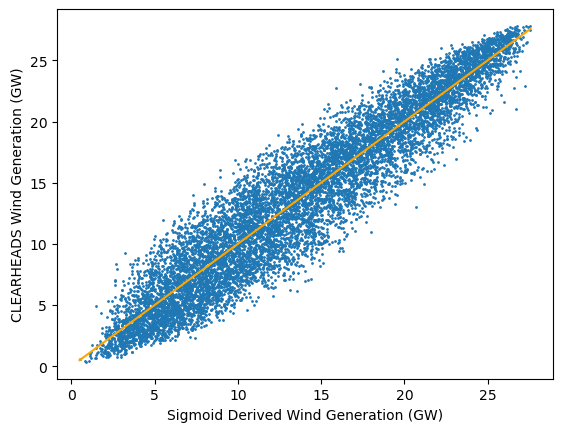

In [71]:
# add a new column - wind_gen_derived
df["wind_gen_derived"] = sigmoid(df['10m_wind_speed'], *popt)

# set up a figure
fig, ax = plt.subplots()

# plot the scatter of the observed wind generation against the derived wind generation
ax.scatter(df["wind_gen_derived"], df["wind_gen"], s=1)

# include a 1:1 line
x = np.linspace(min(df["wind_gen_derived"]), max(df["wind_gen_derived"]), 100)

ax.plot(x, x, 'r-', color='orange')

# include the axis labels
ax.set_xlabel("Sigmoid Derived Wind Generation (GW)")
ax.set_ylabel("CLEARHEADS Wind Generation (GW)")

Now we want to perform many sigmoid fits using bootstrapping to quantify the uncertainty around this.

In [27]:
df.keys()

Index(['solar_power', '100m_wind_speed', '10m_wind_speed', 'solar_irradiance',
       'ofs_cfs', 'ons_cfs', 't2m_no_detrend', 't2m_2020_detrend',
       'United_Kingdom_demand', 'United_Kingdom_wd_demand', 'wind_gen',
       'demand_net_wind', 'wd_demand_net_wind', 'wind_gen_derived'],
      dtype='object')

In [33]:
from tqdm import tqdm
import random

In [54]:
%%time

# Set up the column names
x_col_name = "10m_wind_speed" # predictor
y_col_name = "wind_gen" # target

# Set up the block length - 10 days independent
block_length = 10

# set up the number of trials
nboot = 1000
num_trials = 1000

# Set up the ntimes for the obs
ntimes = len(df_obs_tas["time"].unique())

# Get the number of blocks
nblocks = int(ntimes / block_length)

# if the nblocks * block is less than the ntimes
if (nblocks * block_length) < ntimes:
    # add one to the nblocks
    nblocks = nblocks + 1

# set up the index for time
index_time = range(ntimes - block_length + 1)

# Set up empty arrays for the bootstrapped data
x_boot_full = np.zeros([nboot, ntimes])
y_boot_full = np.zeros([nboot, ntimes])

# Set up an empty array for the residuals
residuals_boot = np.zeros((nboot, ntimes))

# Set up an empty array for the spread
res_spread_boot = np.zeros(nboot)

# set up an empty array for the r2 and rmse values
r2_boot = np.zeros(nboot)
rmse_boot = np.zeros(nboot)

# Loop over the nboot
for iboot in tqdm(np.arange(nboot)):
    # Select starting indices for the blocks
    if iboot == 0:
        ind_time_this = range(0, ntimes, block_length)
    else:  # random samples
        ind_time_this = np.array(
            [random.choice(index_time) for _ in range(nblocks)]
        )

    # Set up the shape of the bootstrapped data
    x_boot = np.zeros(ntimes)
    y_boot = np.zeros(ntimes)

    # Reset the time index
    itime = 0

    # Loop over the indices
    for ithis in ind_time_this:
        # Set up the block index
        ind_block = np.arange(ithis, ithis + block_length)

        # if the block index is greater than the number of times
        # then subtract the number of times from the block index
        ind_block[(ind_block > ntimes - 1)] = (
            ind_block[(ind_block > ntimes - 1)] - ntimes
        )

        # Restrict the block index to the minimum of the block length
        ind_block = ind_block[: min(block_length, ntimes - itime)]

        # loop over the individual blocks
        for iblock in ind_block:
            # set the bootstrapped data
            x_boot[itime] = df[x_col_name].values[iblock]
            y_boot[itime] = df[y_col_name].values[iblock]

            # increment the time index
            itime = itime + 1

    # Append the data
    x_boot_full[iboot, :] = x_boot
    y_boot_full[iboot, :] = y_boot

    # If this is the first bootstrapped sample
    if iboot == 0: # first sample
        # set up the sigmoid fit
        popt_first, pcov_first = curve_fit(
            sigmoid, x_boot, y_boot, p0=p0, method="dogbox"
        )

        # Make the precitions of y
        y_pred_first = sigmoid(x_boot, *popt_first)

        # Calculate the first r2 value
        r2_first = r2_score(y_boot, y_pred_first)

        # Calculate the first rmse value
        rmse_first = mean_squared_error(y_boot, y_pred_first)

        # Calculae the first residuals
        residuals_first = y_pred_first - y_boot

        # Calculate the spread of the residuals
        res_spread_first = np.std(residuals_first)
    else: # random samples
        # set up the sigmoid fit
        popt_this, pcov_this = curve_fit(
            sigmoid, x_boot, y_boot, p0=p0, method="dogbox"
        )

        # Make the precitions of y
        y_pred_this = sigmoid(x_boot, *popt_this)

        # Calculate the r2 value
        r2_this = r2_score(y_boot, y_pred_this)

        # Calculate the rmse value
        rmse_this = mean_squared_error(y_boot, y_pred_this)

        # Calculate the residuals
        residuals_this = y_pred_this - y_boot

        # Calculate the spread of the residuals
        res_spread_this = np.std(residuals_this)

        # Append the residuals
        residuals_boot[iboot, :] = residuals_this

        # Append the spread of the residuals
        res_spread_boot[iboot] = res_spread_this

        # Append the r2 and rmse values
        r2_boot[iboot] = r2_this
        rmse_boot[iboot] = rmse_this

# Quantify the 5th, 50th and 95th percentiles of the residual std
res_spread_5th = np.percentile(res_spread_boot, 5)
res_spread_50th = np.percentile(res_spread_boot, 50)
res_spread_95th = np.percentile(res_spread_boot, 95)

# Print the estimates of the residuals
print(f"5th percentile of the residuals sigma: {res_spread_5th}")
print(f"50th percentile of the residuals sigma: {res_spread_50th}")
print(f"95th percentile of the residuals sigma: {res_spread_95th}")

# Create a stochastic fit with the upper bounds of the spread
stoch_95 = np.random.normal(0, res_spread_95th, size=(len(df["10m_wind_speed"]), num_trials))

# Create a stochastic fit with the lower bounds of the spread
stoch_5 = np.random.normal(0, res_spread_5th, size=(len(df["10m_wind_speed"]), num_trials))

# Create a stochastic fit with the median bounds of the spread
stoch_50 = np.random.normal(0, res_spread_50th, size=(len(df["10m_wind_speed"]), num_trials))

# create a new column for the stochastic fit
df["wind_gen_pred"] = y_pred_first

# add the random trials to the deterministic model time series
trials_95 = pd.DataFrame(
    df["wind_gen_pred"].values[:, np.newaxis] + stoch_95,
    index=df.index,
    columns=range(num_trials),
)

trials_5 = pd.DataFrame(
    df["wind_gen_pred"].values[:, np.newaxis] + stoch_5,
    index=df.index,
    columns=range(num_trials),
)

trials_50 = pd.DataFrame(
    df["wind_gen_pred"].values[:, np.newaxis] + stoch_50,
    index=df.index,
    columns=range(num_trials),
)

# Group the trials by day and calculate the mean
trials_95_grp_mean = trials_95.groupby(trials_95.index.date).mean()
trials_5_grp_mean = trials_5.groupby(trials_5.index.date).mean()
trials_50_grp_mean = trials_50.groupby(trials_50.index.date).mean()

# cacllate the 5th and 95th percentiles of the trials
p05_95, p95_95 = [trials_95_grp_mean.T.quantile(x) for x in [0.05, 0.95]]

p05_05, p95_05 = [trials_5_grp_mean.T.quantile(x) for x in [0.05, 0.95]]

p05_50, p95_50 = [trials_50_grp_mean.T.quantile(x) for x in [0.05, 0.95]]


# Convert these all to dataframes
p05_95 = p05_95.to_frame() ; p95_95 = p95_95.to_frame()
p05_05 = p05_05.to_frame() ; p95_05 = p95_05.to_frame()
p05_50 = p05_50.to_frame() ; p95_50 = p95_50.to_frame()

# reset the index
p05_95.reset_index(inplace=True) ; p95_95.reset_index(inplace=True)
p05_05.reset_index(inplace=True) ; p95_05.reset_index(inplace=True)
p05_50.reset_index(inplace=True) ; p95_50.reset_index(inplace=True)


# Set the column names
p05_95.columns = ["index", f"{y_col_name}_p05_95"]
p95_95.columns = ["index", f"{y_col_name}_p95_95"]

p05_05.columns = ["index", f"{y_col_name}_p05_05"]
p95_05.columns = ["index", f"{y_col_name}_p95_05"]

p05_50.columns = ["index", f"{y_col_name}_p05_50"]
p95_50.columns = ["index", f"{y_col_name}_p95_50"]

# add these columns to the full dataframe
# matching where the index is the same as the "index" column in the p05_95 dataframe
df = df.merge(p05_95, left_on="date", right_on="index", how="left")

100%|██████████| 1000/1000 [01:56<00:00,  8.60it/s]


5th percentile of the residuals sigma: 2.1544482634507682
50th percentile of the residuals sigma: 2.1819123878154993
95th percentile of the residuals sigma: 2.2099141232043538


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [56]:
p05_95.head()

,index,wind_gen_p05_95
0,1960-01-01,8.871385
1,1960-01-02,0.800061
2,1960-01-03,6.894808
3,1960-01-04,13.649724
4,1960-01-05,12.551832


In [55]:
df.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,...,demand_net_wind,wd_demand_net_wind,wind_gen_derived,wind_gen_pred,wind_gen_p05_95,wind_gen_p95_95,wind_gen_p05_05,wind_gen_p95_05,wind_gen_p05_50,wind_gen_p95_50
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,...,25.022648,25.922391,12.220771,12.220771,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,...,36.135318,39.979230,4.448387,4.448387,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,...,29.590107,34.280923,10.507048,10.507048,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,...,26.599156,27.407426,17.033797,17.033797,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,...,25.382651,25.382651,16.087564,16.087564,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# ensure that the index is a datetime object
p05_95["index"] = pd.to_datetime(p05_95["index"])
p95_95["index"] = pd.to_datetime(p95_95["index"])

p05_05["index"] = pd.to_datetime(p05_05["index"])
p95_05["index"] = pd.to_datetime(p95_05["index"])

p05_50["index"] = pd.to_datetime(p05_50["index"])
p95_50["index"] = pd.to_datetime(p95_50["index"])

# set this as the index
p05_95.set_index("index", inplace=True)
p95_95.set_index("index", inplace=True)

p05_05.set_index("index", inplace=True)
p95_05.set_index("index", inplace=True)

p05_50.set_index("index", inplace=True)
p95_50.set_index("index", inplace=True)

In [60]:
# add new columsn in df
df[f"{y_col_name}_p05_95"] = p05_95[f"{y_col_name}_p05_95"]
df[f"{y_col_name}_p95_95"] = p95_95[f"{y_col_name}_p95_95"]

df[f"{y_col_name}_p05_05"] = p05_05[f"{y_col_name}_p05_05"]
df[f"{y_col_name}_p95_05"] = p95_05[f"{y_col_name}_p95_05"]

df[f"{y_col_name}_p05_50"] = p05_50[f"{y_col_name}_p05_50"]
df[f"{y_col_name}_p95_50"] = p95_50[f"{y_col_name}_p95_50"]

In [62]:
# limit df to the first 90 days
df_limit = df[:90]

In [63]:
df_limit.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,...,demand_net_wind,wd_demand_net_wind,wind_gen_derived,wind_gen_pred,wind_gen_p05_95,wind_gen_p95_95,wind_gen_p05_05,wind_gen_p95_05,wind_gen_p05_50,wind_gen_p95_50
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,...,25.022648,25.922391,12.220771,12.220771,8.871385,15.977531,8.524999,15.724282,8.981899,15.417704
1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,...,36.135318,39.979230,4.448387,4.448387,0.800061,8.049078,0.885713,7.845556,0.979025,8.040885
1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,...,29.590107,34.280923,10.507048,10.507048,6.894808,14.141011,6.942562,14.140107,6.901562,14.173925
1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,...,26.599156,27.407426,17.033797,17.033797,13.649724,20.833161,13.510002,20.521043,13.304743,20.943243
1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,...,25.382651,25.382651,16.087564,16.087564,12.551832,19.686936,12.519218,19.593642,12.486411,19.708082


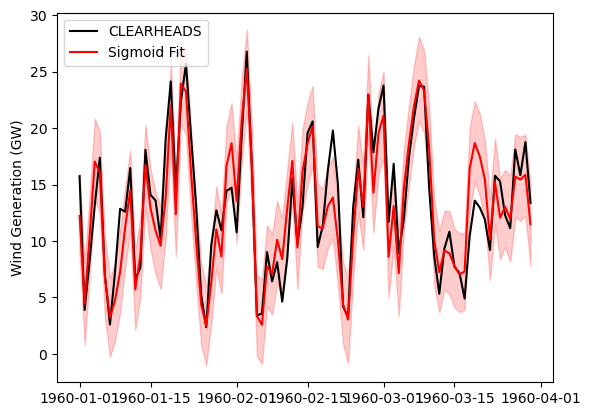

In [64]:
# Plot the central estimate and the 5-95th percentile
fig, ax = plt.subplots()

# Plot the first 100 value of wind gen
ax.plot(df_limit["wind_gen"], label="CLEARHEADS", color='black')

# Plot the predicted values in red
ax.plot(df_limit["wind_gen_pred"], label="Sigmoid Fit", color='red')

# Plot the 5th and 95th percentiles
ax.fill_between(
    df_limit.index,
    df_limit["wind_gen_p05_95"],
    df_limit["wind_gen_p95_95"],
    color="red",
    alpha=0.2,
)

# # Set the axis labels
# ax.set_xlabel("Time")

ax.set_ylabel("Wind Generation (GW)")

# Include a legend in the top left
ax.legend(loc="upper left")

/tmp/ipykernel_805556/1998617988.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, x, 'r-', color='orange', label="1:1 Line")
/tmp/ipykernel_805556/1998617988.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, model_5.predict(x.reshape(-1, 1)), 'r--', color='red', label="5th-95th Percentile Fit")
/tmp/ipykernel_805556/1998617988.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, model_95.predict(x.reshape(-1, 1)), 'r--', color='red')


Text(0, 0.5, 'CLEARHEADS Wind Generation (GW)')

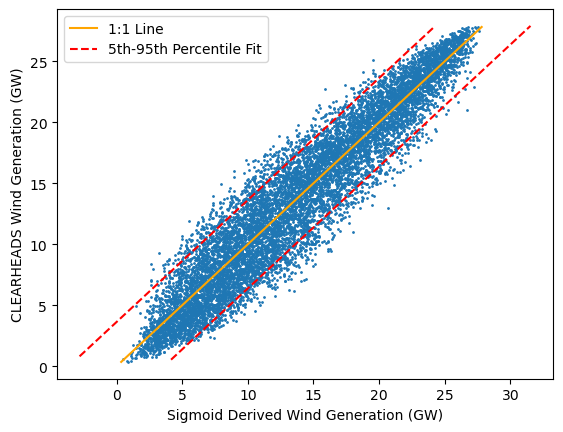

In [76]:
# Scatter plot of the observed wind generation against the predicted wind generation
fig, ax = plt.subplots()

# plot the scatter of the observed wind generation against the predicted wind generation
ax.scatter(df["wind_gen_pred"], df["wind_gen"], s=1)

# include a 1:1 line
x = np.linspace(min(df["wind_gen"]), max(df["wind_gen"]), 100)

ax.plot(x, x, 'r-', color='orange', label="1:1 Line")

# create a simple linear fit for the 5th percentile
model_5 = LinearRegression()

# fit the model to the data
model_5.fit(df["wind_gen_p05_95"].values.reshape(-1, 1), df["wind_gen"].values.reshape(-1, 1))

# create a simple linear fit for the 95th percentile
model_95 = LinearRegression()

# fit the model to the data
model_95.fit(df["wind_gen_p95_95"].values.reshape(-1, 1), df["wind_gen"].values.reshape(-1, 1))

# plot the linear regression fit for the 5th percentile as a dahsed red line
x = np.linspace(min(df["wind_gen_p05_95"]), max(df["wind_gen_p05_95"]), 100)

ax.plot(x, model_5.predict(x.reshape(-1, 1)), 'r--', color='red', label="5th-95th Percentile Fit")

# plot the linear regression fit for the 95th percentile as a dashed red line
x = np.linspace(min(df["wind_gen_p95_95"]), max(df["wind_gen_p95_95"]), 100)

ax.plot(x, model_95.predict(x.reshape(-1, 1)), 'r--', color='red')

# # plot the scatter of the of the 5th and 95th percentiles
# ax.scatter(df["wind_gen_p05_95"], df["wind_gen"], s=1, color='red')

# ax.scatter(df["wind_gen_p95_95"], df["wind_gen"], s=1, color='red')

# include a legend in the top left
ax.legend(loc="upper left")

# include the axis labels
ax.set_xlabel("Sigmoid Derived Wind Generation (GW)")
ax.set_ylabel("CLEARHEADS Wind Generation (GW)")

Most points captured in the uncertainty range around the deterministic fit

We want to propogate this wind generation uncertainty through to the no. exceedance days and severity count to see how much it affects these final totals.

In [66]:
df.keys()

Index(['solar_power', '100m_wind_speed', '10m_wind_speed', 'solar_irradiance',
       'ofs_cfs', 'ons_cfs', 't2m_no_detrend', 't2m_2020_detrend',
       'United_Kingdom_demand', 'United_Kingdom_wd_demand', 'wind_gen',
       'demand_net_wind', 'wd_demand_net_wind', 'wind_gen_derived',
       'wind_gen_pred', 'wind_gen_p05_95', 'wind_gen_p95_95',
       'wind_gen_p05_05', 'wind_gen_p95_05', 'wind_gen_p05_50',
       'wind_gen_p95_50'],
      dtype='object')

In [67]:
df_obs_tas.keys()

Index(['time', 'data', 'tas_c', 'hdd', 'cdd', 'UK_demand'], dtype='object')

In [91]:
# set time as datetime
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

# set time as the index
df_obs_tas.set_index("time", inplace=True)

In [97]:
# Create a new column for demand
full_df["ERA5_derived_demand"] = df_obs_tas["UK_demand"]

In [98]:
full_df["ERA5_derived_demand"].describe()

count    10753.000000
mean        42.351870
std          2.597833
min         35.056087
25%         40.579675
50%         42.379225
75%         44.111282
max         51.833628
Name: ERA5_derived_demand, dtype: float64

In [99]:
# Calculate the deterministic demand net wind generation
full_df["wd_demand_net_wind_derived"] = full_df["ERA5_derived_demand"] - full_df["wind_gen_pred"]

# create a new column for the 5th and 95th percentiles
full_df["wd_demand_net_wind_p05_95"] = full_df["ERA5_derived_demand"] - full_df["wind_gen_p05_95"]
full_df["wd_demand_net_wind_p95_95"] = full_df["ERA5_derived_demand"] - full_df["wind_gen_p95_95"]

In [79]:
df.keys()

Index(['solar_power', '100m_wind_speed', '10m_wind_speed', 'solar_irradiance',
       'ofs_cfs', 'ons_cfs', 't2m_no_detrend', 't2m_2020_detrend',
       'United_Kingdom_demand', 'United_Kingdom_wd_demand', 'wind_gen',
       'demand_net_wind', 'wd_demand_net_wind', 'wind_gen_derived',
       'wind_gen_pred', 'wind_gen_p05_95', 'wind_gen_p95_95',
       'wind_gen_p05_05', 'wind_gen_p95_05', 'wind_gen_p05_50',
       'wind_gen_p95_50', 'ERA5_derived_demand', 'wd_demand_net_wind_derived',
       'wd_demand_net_wind_p05_95', 'wd_demand_net_wind_p95_95'],
      dtype='object')

In [80]:
# rename df
full_df = df

In [107]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))
severity_index_deriv = np.zeros(len(winter_years))
severity_index_deriv_05 = np.zeros(len(winter_years))
severity_index_deriv_95 = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))
no_exceedance_days_deriv = np.zeros(len(winter_years))
no_exceedance_days_deriv_05 = np.zeros(len(winter_years))
no_exceedance_days_deriv_95 = np.zeros(len(winter_years))

# winter mean dnw
winter_mean_dnw = np.zeros(len(winter_years))
winter_mean_dnw_deriv = np.zeros(len(winter_years))
winter_mean_dnw_deriv_05 = np.zeros(len(winter_years))
winter_mean_dnw_deriv_95 = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []

# 92nd percentile of CLEARHEADS wd demand net wind
all_winters_92 = np.percentile(full_df["wd_demand_net_wind"], 92)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = full_df.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask_ch = df["wd_demand_net_wind"] > all_winters_92
    mask_deriv = df["wd_demand_net_wind_derived"] > all_winters_92
    mask_deriv_05 = df["wd_demand_net_wind_p05_95"] > all_winters_92
    mask_deriv_95 = df["wd_demand_net_wind_p95_95"] > all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["wd_demand_net_wind"][mask_ch] - all_winters_92).sum()
    severity_index_deriv[i] = (df["wd_demand_net_wind_derived"][mask_deriv] - all_winters_92).sum()
    severity_index_deriv_05[i] = (df["wd_demand_net_wind_p05_95"][mask_deriv_05] - all_winters_92).sum()
    severity_index_deriv_95[i] = (df["wd_demand_net_wind_p95_95"][mask_deriv_95] - all_winters_92).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask_ch.sum()
    no_exceedance_days_deriv[i] = mask_deriv.sum()
    no_exceedance_days_deriv_05[i] = mask_deriv_05.sum()
    no_exceedance_days_deriv_95[i] = mask_deriv_95.sum()

    # winter mean dnw
    winter_mean_dnw[i] = df["wd_demand_net_wind"][mask_ch].mean()
    winter_mean_dnw_deriv[i] = df["wd_demand_net_wind_derived"][mask_deriv].mean()
    winter_mean_dnw_deriv_05[i] = df["wd_demand_net_wind_p05_95"][mask_deriv_05].mean()
    winter_mean_dnw_deriv_95[i] = df["wd_demand_net_wind_p95_95"][mask_deriv_95].mean()

    # format the dates to yyyy-mm-dd
    dates = df.index[mask_ch].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask_ch])

    # Add the exceedance values to the list
    exceedance_values.extend(df["wd_demand_net_wind"][mask_ch])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity_ch": severity_index,
        "no_exceedance_days_ch": no_exceedance_days,
        "severity_deriv": severity_index_deriv,
        "no_exceedance_days_deriv": no_exceedance_days_deriv,
        "severity_deriv_05": severity_index_deriv_05,
        "no_exceedance_days_deriv_05": no_exceedance_days_deriv_05,
        "severity_deriv_95": severity_index_deriv_95,
        "no_exceedance_days_deriv_95": no_exceedance_days_deriv_95,
        "winter_mean_dnw_ch": winter_mean_dnw,
        "winter_mean_dnw_deriv": winter_mean_dnw_deriv,
        "winter_mean_dnw_deriv_05": winter_mean_dnw_deriv_05,
        "winter_mean_dnw_deriv_95": winter_mean_dnw_deriv_95,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [101]:
full_df.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,...,wind_gen_p05_95,wind_gen_p95_95,wind_gen_p05_05,wind_gen_p95_05,wind_gen_p05_50,wind_gen_p95_50,ERA5_derived_demand,wd_demand_net_wind_derived,wd_demand_net_wind_p05_95,wd_demand_net_wind_p95_95
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,...,8.871385,15.977531,8.524999,15.724282,8.981899,15.417704,41.519602,29.298831,32.648217,25.542071
1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,...,0.800061,8.049078,0.885713,7.845556,0.979025,8.040885,43.840163,39.391776,43.040102,35.791085
1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,...,6.894808,14.141011,6.942562,14.140107,6.901562,14.173925,42.451549,31.944501,35.556741,28.310538
1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,...,13.649724,20.833161,13.510002,20.521043,13.304743,20.943243,40.617652,23.583855,26.967928,19.784491
1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,...,12.551832,19.686936,12.519218,19.593642,12.486411,19.708082,42.626252,26.538688,30.074420,22.939316


In [108]:
df_exceedance_days_obs.head()

,severity_ch,no_exceedance_days_ch,severity_deriv,no_exceedance_days_deriv,severity_deriv_05,no_exceedance_days_deriv_05,severity_deriv_95,no_exceedance_days_deriv_95,winter_mean_dnw_ch,winter_mean_dnw_deriv,winter_mean_dnw_deriv_05,winter_mean_dnw_deriv_95
1960,35.786467,18.0,21.079647,11.0,106.689613,32.0,0.495721,1.0,41.644238,41.572432,42.990151,40.151822
1961,73.972244,34.0,56.266289,29.0,203.132151,55.0,5.299711,3.0,41.831755,41.596318,43.349413,41.422671
1962,130.330120,38.0,111.054781,38.0,307.782497,72.0,19.188860,12.0,43.085841,42.578595,43.930858,41.255172
1963,31.710833,20.0,25.260148,15.0,149.414375,52.0,0.289032,1.0,41.241642,41.340111,42.529454,39.945132
1964,37.343381,21.0,24.935426,16.0,161.325443,60.0,0.690074,1.0,41.434357,41.214565,42.344858,40.346175


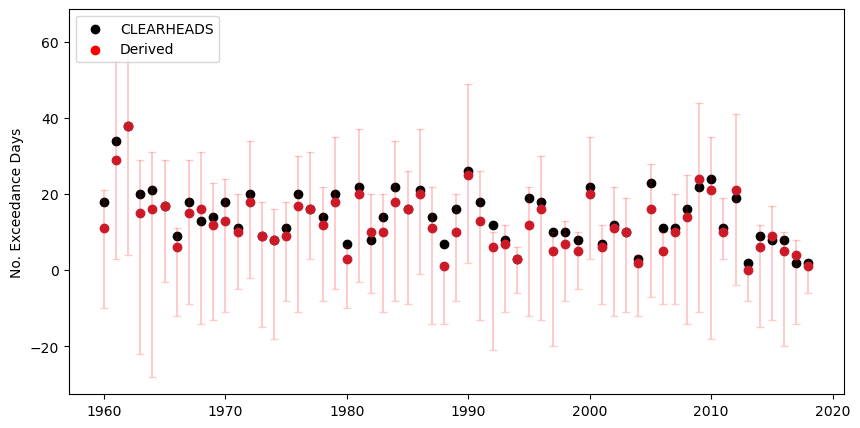

In [105]:
# plot the verificaion of the exceedance days
fig, ax = plt.subplots(figsize=(10, 5))

# plot the number of exceedance daysn ch estimate
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["no_exceedance_days_ch"], label="CLEARHEADS", color='black')

# plot the number of exceedance days derived
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["no_exceedance_days_deriv"], label="Derived", color='red')

# Calculate the error values
y = df_exceedance_days_obs["no_exceedance_days_deriv"]
yerr = [
    df_exceedance_days_obs["no_exceedance_days_deriv_05"] - y,
    y - df_exceedance_days_obs["no_exceedance_days_deriv_95"]
]

# Plot the error bars
ax.errorbar(
    df_exceedance_days_obs.index,
    y,
    yerr=yerr,
    fmt='o',  # Marker style
    ecolor='red',  # Error bar color
    alpha=0.2,  # Transparency of error bars
    capsize=3,  # Length of error bar caps
    linestyle='None'  # No line connecting the markers
)

# Set up the y-label
ax.set_ylabel("No. Exceedance Days")

# set up the legend in the top left
ax.legend(loc="upper left")

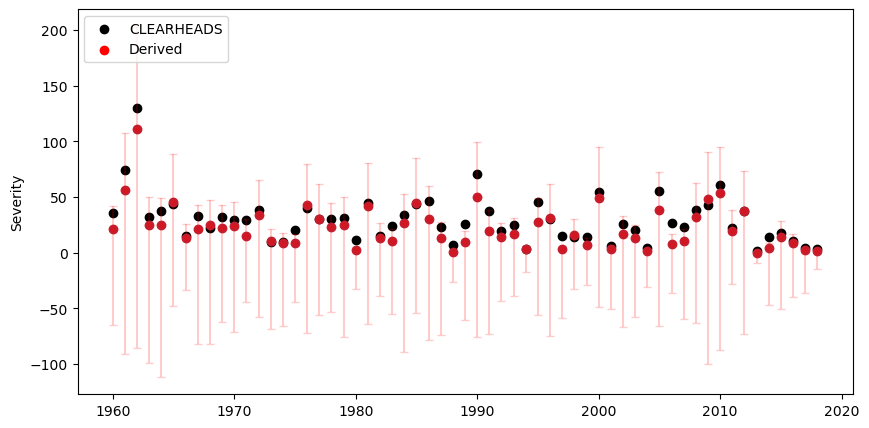

In [106]:
# plot the verificaion of the exceedance days
fig, ax = plt.subplots(figsize=(10, 5))

# plot the number of exceedance daysn ch estimate
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["severity_ch"], label="CLEARHEADS", color='black')

# plot the number of exceedance days derived
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["severity_deriv"], label="Derived", color='red')

# Calculate the error values
y = df_exceedance_days_obs["severity_deriv"]
yerr = [
    df_exceedance_days_obs["severity_deriv_05"] - y,
    y - df_exceedance_days_obs["severity_deriv_95"]
]

# Plot the error bars
ax.errorbar(
    df_exceedance_days_obs.index,
    y,
    yerr=yerr,
    fmt='o',  # Marker style
    ecolor='red',  # Error bar color
    alpha=0.2,  # Transparency of error bars
    capsize=3,  # Length of error bar caps
    linestyle='None'  # No line connecting the markers
)

# Set up the y-label
ax.set_ylabel("Severity")

# set up the legend in the top left
ax.legend(loc="upper left")

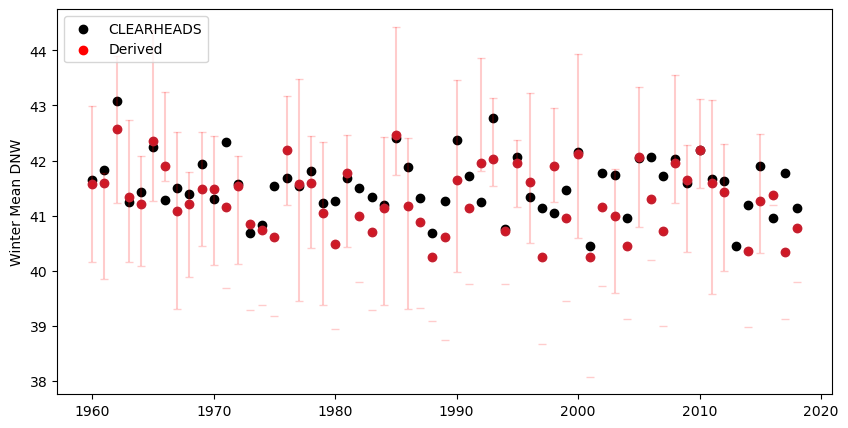

In [112]:
# plot the verificaion of the exceedance days
fig, ax = plt.subplots(figsize=(10, 5))

# plot the number of exceedance daysn ch estimate
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["winter_mean_dnw_ch"], label="CLEARHEADS", color='black')

# plot the number of exceedance days derived
ax.scatter(df_exceedance_days_obs.index, df_exceedance_days_obs["winter_mean_dnw_deriv"], label="Derived", color='red')

# Calculate the error values
y = df_exceedance_days_obs["winter_mean_dnw_deriv"]
yerr = [
    abs(df_exceedance_days_obs["winter_mean_dnw_deriv_05"] - y),
    abs(y - df_exceedance_days_obs["winter_mean_dnw_deriv_95"])
]

# Plot the error bars
ax.errorbar(
    df_exceedance_days_obs.index,
    y,
    yerr=yerr,
    fmt='o',  # Marker style
    ecolor='red',  # Error bar color
    alpha=0.2,  # Transparency of error bars
    capsize=3,  # Length of error bar caps
    linestyle='None'  # No line connecting the markers
)

# Set up the y-label
ax.set_ylabel("Winter Mean DNW")

# set up the legend in the top left
ax.legend(loc="upper left")